## Supervised Learning Potpourri
# 3 - Housing Prices
### Sam Fradkin

Using [this Kaggle data](https://www.kaggle.com/anthonypino/melbourne-housing-market) create a model to predict a house's value. We want to be able to understand what creates value in a house, as though we were a real estate developer.

In [1]:
%%HTML
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton"
value="Show Code"></form>

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

from xgboost                   import XGBRegressor
from sklearn                   import ensemble
from sklearn.utils             import resample
from sklearn.metrics           import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble          import RandomForestRegressor
from sklearn.model_selection   import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectKBest

import warnings
warnings.filterwarnings('ignore')

# 1) Data Overview

Let's take a look at the data provided to us.

In [3]:
df = pd.read_csv('Melbourne Housing.csv')

In [4]:
df.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Postcode,Regionname,Propertycount,Distance,CouncilArea
0,Abbotsford,49 Lithgow St,3,h,1490000.0,S,Jellis,1/04/2017,3067,Northern Metropolitan,4019,3.0,Yarra City Council
1,Abbotsford,59A Turner St,3,h,1220000.0,S,Marshall,1/04/2017,3067,Northern Metropolitan,4019,3.0,Yarra City Council
2,Abbotsford,119B Yarra St,3,h,1420000.0,S,Nelson,1/04/2017,3067,Northern Metropolitan,4019,3.0,Yarra City Council
3,Aberfeldie,68 Vida St,3,h,1515000.0,S,Barry,1/04/2017,3040,Western Metropolitan,1543,7.5,Moonee Valley City Council
4,Airport West,92 Clydesdale Rd,2,h,670000.0,S,Nelson,1/04/2017,3042,Western Metropolitan,3464,10.4,Moonee Valley City Council


Shape of the dataframe (rows, columns):

In [5]:
df.shape

(63023, 13)

Dataframe info:

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63023 entries, 0 to 63022
Data columns (total 13 columns):
Suburb           63023 non-null object
Address          63023 non-null object
Rooms            63023 non-null int64
Type             63023 non-null object
Price            48433 non-null float64
Method           63023 non-null object
SellerG          63023 non-null object
Date             63023 non-null object
Postcode         63023 non-null int64
Regionname       63023 non-null object
Propertycount    63023 non-null int64
Distance         63023 non-null float64
CouncilArea      63023 non-null object
dtypes: float64(2), int64(3), object(8)
memory usage: 6.3+ MB


Dataframe describe:

In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Rooms,63023.0,3.110595,0.957551,1.0,3.0,3.0,4.0,31.0
Price,48433.0,997898.241488,593498.919037,85000.0,620000.0,830000.0,1220000.0,11200000.0
Postcode,63023.0,3125.673897,125.626877,3000.0,3056.0,3107.0,3163.0,3980.0
Propertycount,63023.0,7617.728131,4424.423167,39.0,4380.0,6795.0,10412.0,21650.0
Distance,63023.0,12.684829,7.592015,0.0,7.0,11.4,16.7,64.1


Unique values per column:

In [8]:
df.nunique()

Suburb             380
Address          57754
Rooms               14
Type                 3
Price             3417
Method               9
SellerG            476
Date               112
Postcode           225
Regionname           8
Propertycount      368
Distance           180
CouncilArea         34
dtype: int64

# 2) Data Cleaning

Here we will make sure all features are usable for prediction purposes as well as removing all unnecessary data.

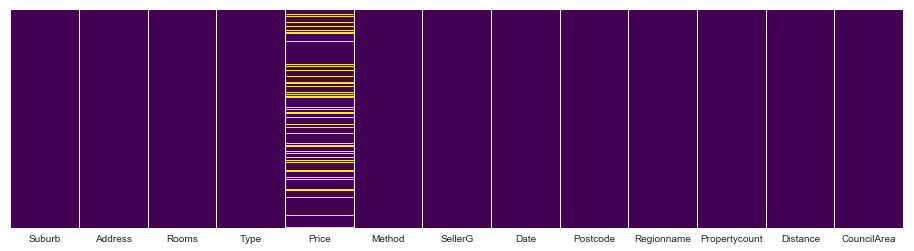

In [9]:
# Create a heatmap of null values to see how prevalent they are and how to address them
plt.figure(figsize=(16,4))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.show()

It looks like our Price column is missing a lot of data. Being that Price is our target feature, we should drop any rows that have missing pricing data.<br><br>
First let's rename some columns. Then let's see if we can convert any of the object-type columns into usable features.

In [10]:
# Rename some columns
df.rename({'SellerG':'Seller', 'Regionname':'Region', 'Propertycount':'PropCount',
              'CouncilArea':'Council'}, axis=1, inplace=True)

In [11]:
# Remove rows with missing PRICE data
df.dropna(subset=['Price'], inplace=True)

In [12]:
# Make the categorical variable 'Type' into dummies
df = pd.concat([df, pd.get_dummies(df['Type'])], axis = 1)

# Remove the original 'Type' column and rename the new columns
df.drop(['Type'], axis = 1, inplace = True)
df.rename(columns={'h': 'Type-H', 't': 'Type-T', 'u': 'Type-U'}, inplace=True)

In [13]:
# Convert DATE column to usable format type
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.month

In [14]:
# Let's convert categorical columns into integers so they can be incorporated into our model
# Convert each column to a list
suburb  = df['Suburb' ].unique()
method  = df['Method' ].unique()
region  = df['Region' ].unique()
council = df['Council'].unique()

# Rename each cell with the corresponding position in the list
df['SuburbNum' ] = df['Suburb' ].apply(lambda x: int(np.argwhere(suburb == x)[0][0]) + 1)
df['MethodNum' ] = df['Method' ].apply(lambda x: int(np.argwhere(method == x)[0][0]) + 1)
df['RegionNum' ] = df['Region' ].apply(lambda x: int(np.argwhere(region == x)[0][0]) + 1)
df['CouncilNum'] = df['Council'].apply(lambda x: int(np.argwhere(council== x)[0][0]) + 1)

In [15]:
df.head()

,Suburb,Address,Rooms,Price,Method,Seller,Date,Postcode,Region,PropCount,Distance,Council,Type-H,Type-T,Type-U,SuburbNum,MethodNum,RegionNum,CouncilNum
0,Abbotsford,49 Lithgow St,3,1490000.0,S,Jellis,1,3067,Northern Metropolitan,4019,3.0,Yarra City Council,1,0,0,1,1,1,1
1,Abbotsford,59A Turner St,3,1220000.0,S,Marshall,1,3067,Northern Metropolitan,4019,3.0,Yarra City Council,1,0,0,1,1,1,1
2,Abbotsford,119B Yarra St,3,1420000.0,S,Nelson,1,3067,Northern Metropolitan,4019,3.0,Yarra City Council,1,0,0,1,1,1,1
3,Aberfeldie,68 Vida St,3,1515000.0,S,Barry,1,3040,Western Metropolitan,1543,7.5,Moonee Valley City Council,1,0,0,2,1,2,2
4,Airport West,92 Clydesdale Rd,2,670000.0,S,Nelson,1,3042,Western Metropolitan,3464,10.4,Moonee Valley City Council,1,0,0,3,1,2,2


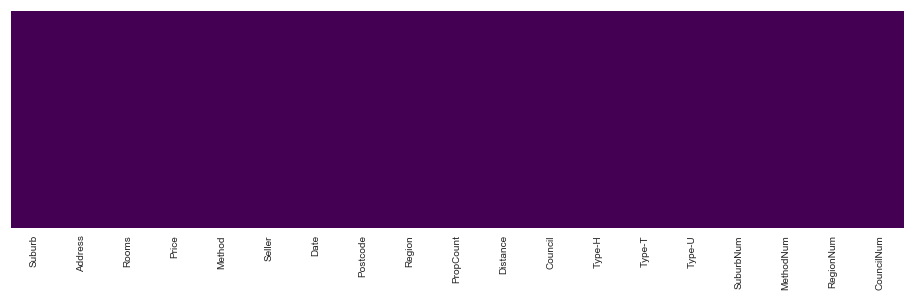

In [16]:
# Let's redo the heatmap of null values to see if we cleaned it all up
plt.figure(figsize=(16,4))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.show()

# 3) Data Analysis

Let's plot some of the data to get a better picture of what is going on here.

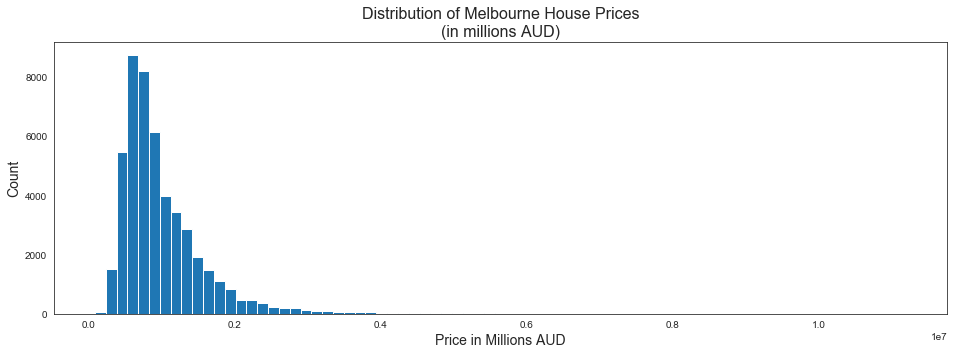

In [17]:
# Plot the distribution of house prices
plt.figure(figsize=(16,5))
plt.hist('Price', bins = 75, range = (df.Price.min(), df.Price.max()), data = df)
plt.title('Distribution of Melbourne House Prices\n(in millions AUD)', fontsize=16)
plt.xlabel('Price in Millions AUD', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.show()

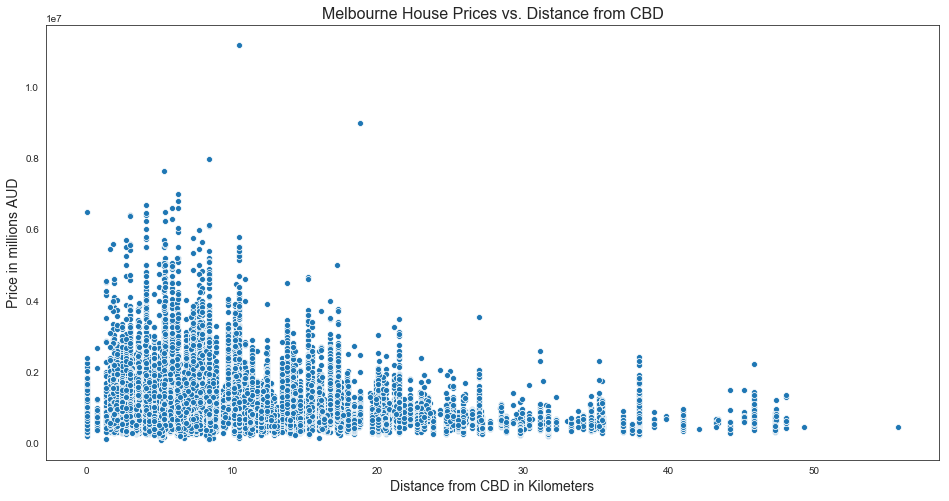

In [18]:
# Scatterplot of house prices vs. Distance from Downtown
plt.figure(figsize=(16,8))
sns.scatterplot(x = 'Distance', y = 'Price', data = df)
plt.title('Melbourne House Prices vs. Distance from CBD', fontsize = 16)
plt.xlabel('Distance from CBD in Kilometers', fontsize = 14)
plt.ylabel('Price in millions AUD', fontsize = 14)
plt.show()

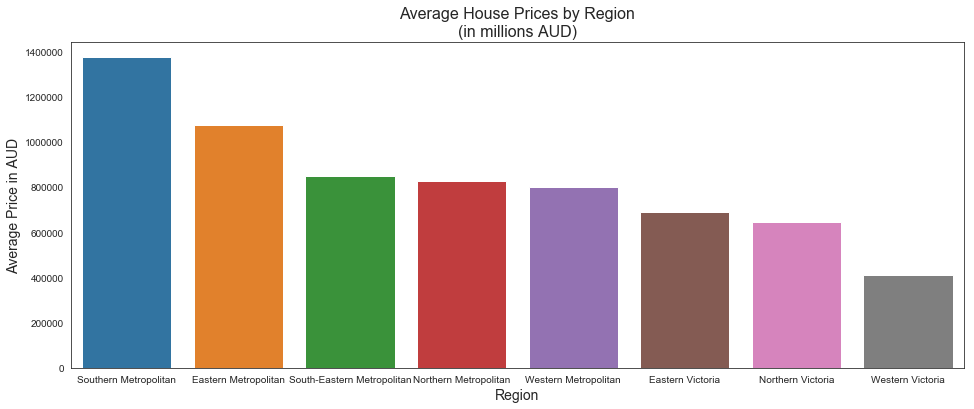

In [19]:
# Sort the SUBURB column to find the average PRICE per suburb
df_reg = df.groupby('Region', as_index = False)['Price'].mean()
df_reg = df_reg.sort_values('Price', ascending = False).reset_index(drop = True)

# Barplot of house prices vs. Distance from Downtown
plt.figure(figsize=(16,6))
sns.barplot(x = 'Region', y = 'Price', data = df_reg, order = df_reg['Region'])
plt.title('Average House Prices by Region\n(in millions AUD)', fontsize=16)
plt.xlabel('Region', fontsize = 14)
plt.ylabel('Average Price in AUD', fontsize = 14)
plt.show()

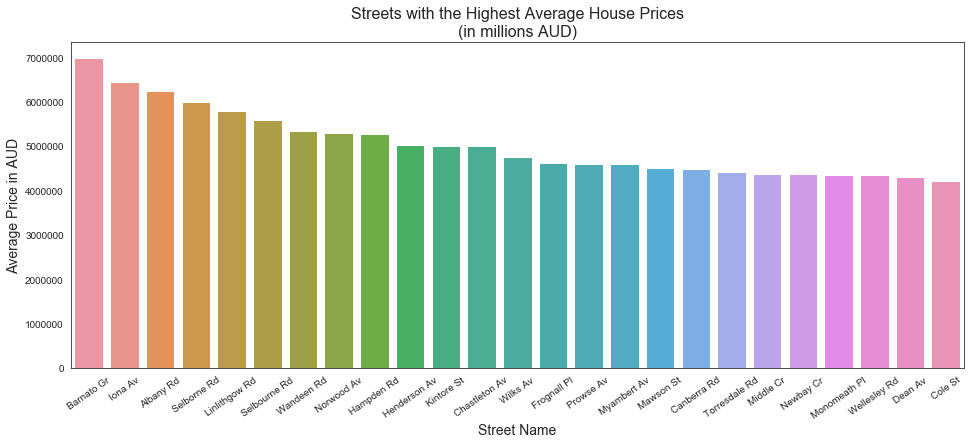

In [20]:
# Get rid of street numbers from the address column so we can plot it.
df['Street'] = df['Address'].apply(lambda x: " ".join(str(x).split()[1:]))

# Sort the STREET column to find the average PRICE per street
df_streets = df.groupby('Street', as_index = False)['Price'].mean()
df_streets = df_streets.sort_values('Price', ascending = False).reset_index(drop = True)
df_streets = df_streets.head(25)

# Barplot of the 25 streets with the hightest prices
plt.figure(figsize=(16,6))
sns.barplot(x = 'Street', y = 'Price', data = df_streets, order = df_streets['Street'])
plt.title('Streets with the Highest Average House Prices\n(in millions AUD)', fontsize=16)
plt.xlabel('Street Name', fontsize = 14)
plt.ylabel('Average Price in AUD', fontsize = 14)
plt.xticks(rotation=35)
plt.show()

# 4) Modeling

Now let's build some models to see if we can predict house prices in this market.<br><br>

First let's begin with creating a dataframe that only includes the columns we want. Then let's pull a heatmap to see how the features correlate.

In [30]:
# Create a dataframe including only the columns we will be using for modeling
df_model = df.drop(['Suburb', 'Address', 'Method', 'Seller', 'Region', 'Council', 'Street'], axis = 1)

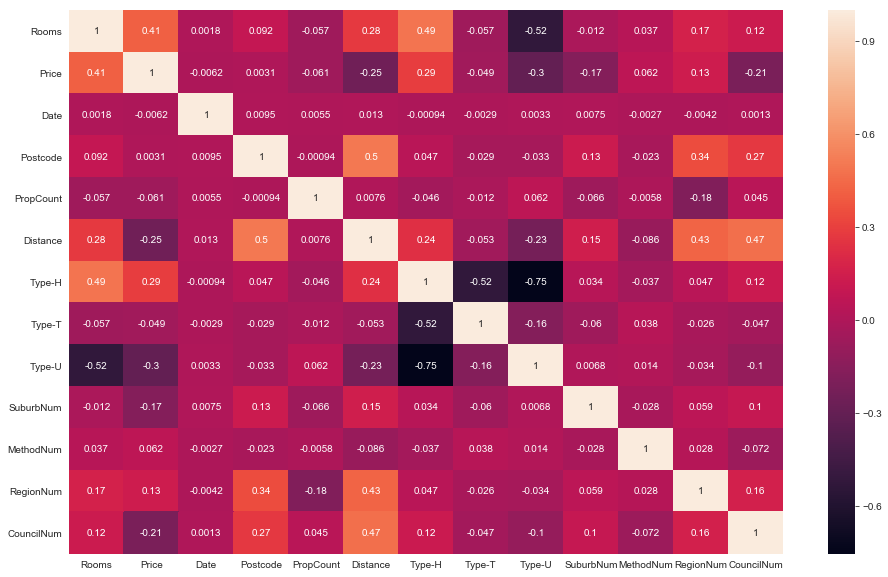

In [34]:
# Create a heatmap of feature correlations
plt.figure(figsize=(16,10))
sns.heatmap(df_model.corr(), annot=True)
plt.show()

## XGBoost Regressor

In [39]:
# Split the data into the target variable and the rest. Remove all categorical features.
X = df_model.drop(['Price'], 1)
y = df['Price']

# Split the data into a training set and a testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101)

In [44]:
# Instantiate the model and fit the data
xgb = XGBRegressor(max_depth = 5, learning_rate = 0.1, n_estimators = 500, colsample_bylevel = 0.4)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.4,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [45]:
predictions = xgb.predict(X_test)
xgbrsq = round(xgb.score(X_test, y_test) * 100, 2)
cvs    = cross_val_score(xgb, X_train, y_train, cv = 5)

In [46]:
print('--- XGBOOST RESULTS ---')
print('R-Squared: ', str(xgbrsq), '%')
print('Cross-Validation Results:')
print(cvs)

--- XGBOOST RESULTS ---
R-Squared:  73.71 %
Cross-Validation Results:
[0.74226089 0.73505618 0.73659578 0.74663624 0.73355673]


In [47]:
# Find the range of te cross-validation results
cvs_min = cvs.min()
cvs_max = cvs.max()
cvs_range = cvs_max - cvs_min
print('Cross-Validation Range')
print(cvs_range)

Cross-Validation Range
0.01307951002718788
